In [1]:
%pip install pandas
%pip install numpy
%pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from itertools import combinations



#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
df_titanic_train = pd.read_csv('titanic_training.csv')

print(df_titanic_train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


PassengerId: Unique id per passenger. We won't use it as a feature for the training of our ML model.

Survived: Categorical, this is the target variable for this problem.

Pclass: Categorical (ordinal), describes the passenger class. It is a proxy for socio-economic status. A priori it is an important feature.

Name: Text. Contains numerous information as the passenger's names and title.

Sex: Categorical (nominal). A priori it is an important feature.

Age: Numerical (continous). A priori it is an important feature.

SibSp: Numerical (discrete). The number of siblings and spouses aboard.

Parch: Numerical (discrete). The number of parents and children aboard.

Ticket: Text. Ticket id.

Fare: Numeric (continous). Price paid for the travel.

Cabin: Text. Contains alphanumeric caracters.

Embarked: Categorical (nominal). Embarkment's port.

In [4]:
print(df_titanic_train.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [5]:
print(df_titanic_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [6]:
# Laden der Daten
df_titanic_train = pd.read_csv('titanic_training.csv')

# Extrahieren des Titels aus dem Namen
df_titanic_train['Title'] = df_titanic_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Mapping der Titel zu numerischen Werten
title_mapping = {
    "Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Dr": 4, "Rev": 5, "Col": 6,
    "Major": 7, "Mlle": 8, "Countess": 9, "Ms": 10, "Lady": 11, "Jonkheer": 12,
    "Don": 13, "Dona": 14, "Mme": 15, "Capt": 16, "Sir": 17
}
df_titanic_train['Title'] = df_titanic_train['Title'].map(title_mapping)

# Drop unnecessary columns and create X and y
X = df_titanic_train.drop(['Survived', 'Cabin', 'Ticket', 'Name'], axis=1)
y = df_titanic_train['Survived']

# Map categorical variables
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})
X['Embarked'] = X['Embarked'].map({'Q': 0, 'S': 1, 'C': 2})

# Entfernen von Zeilen mit fehlenden Werten
X.dropna(inplace=True)

# Ensure that the corresponding rows are removed from y
y = y[X.index]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Liste zur Speicherung der Ergebnisse
results = []

# Iterate over all possible feature combinations
for i in range(1, len(X_train.columns) + 1):
    for combination in combinations(X_train.columns, i):
        X_train_subset = X_train[list(combination)]
        X_val_subset = X_val[list(combination)]
        
        # Find the best n_neighbors for the current feature combination
        for n in range(1, 25):
            knn = KNeighborsClassifier(n_neighbors=n)
            knn.fit(X_train_subset, y_train)
            y_pred = knn.predict(X_val_subset)
            accuracy = accuracy_score(y_val, y_pred)
            
            #print(f"Kombination: {combination}, n_neighbors: {n}, Genauigkeit: {accuracy:.4f}")
            
            # Speicherung der aktuellen Kombination und der Genauigkeit
            results.append((combination, n, accuracy))

# Sortieren der Ergebnisse nach Genauigkeit
results.sort(key=lambda x: x[2], reverse=True)

# Ausgabe der 5 besten Kombinationen
print("Die 5 besten Kombinationen:")
for i in range(5):
    print(f"Kombination: {results[i][0]}, n_neighbors: {results[i][1]}, Genauigkeit: {results[i][2]:.4f}")

# Ausgabe der 5 schlechtesten Kombinationen
print("\nDie 5 schlechtesten Kombinationen:")
for i in range(1, 6):
    print(f"Kombination: {results[-i][0]}, n_neighbors: {results[-i][1]}, Genauigkeit: {results[-i][2]:.4f}")



Die 5 besten Kombinationen:
Kombination: ('Pclass', 'Sex', 'Parch', 'Embarked'), n_neighbors: 5, Genauigkeit: 0.8042
Kombination: ('Pclass', 'SibSp', 'Title'), n_neighbors: 3, Genauigkeit: 0.7972
Kombination: ('Pclass', 'Sex', 'SibSp', 'Title'), n_neighbors: 3, Genauigkeit: 0.7972
Kombination: ('Pclass', 'Sex', 'Parch', 'Embarked'), n_neighbors: 22, Genauigkeit: 0.7972
Kombination: ('Pclass', 'Sex', 'Parch', 'Embarked'), n_neighbors: 23, Genauigkeit: 0.7972

Die 5 schlechtesten Kombinationen:
Kombination: ('Parch', 'Embarked'), n_neighbors: 4, Genauigkeit: 0.3706
Kombination: ('Parch', 'Embarked'), n_neighbors: 13, Genauigkeit: 0.3916
Kombination: ('Embarked',), n_neighbors: 8, Genauigkeit: 0.3986
Kombination: ('Embarked',), n_neighbors: 7, Genauigkeit: 0.3986
Kombination: ('Embarked',), n_neighbors: 6, Genauigkeit: 0.3986


In [7]:
df_titanic_train = pd.read_csv('titanic_training.csv')

# Drop unnecessary columns and create X and y
X = df_titanic_train.drop(['Survived', 'Cabin', 'Ticket', 'Name'], axis=1)
y = df_titanic_train['Survived']

# Map categorical variables
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})
X['Embarked'] = X['Embarked'].map({'Q': 0, 'S': 1, 'C': 2})

# Entfernen von Zeilen mit fehlenden Werten
X.dropna(inplace=True)

# Ensure that the corresponding rows are removed from y
y = y[X.index]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Festes Modell basierend auf der besten Kombination
best_features = ['Pclass', 'Sex', 'Parch', 'Embarked']
n_neighbors = 5

# Modelltraining
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train[best_features], y_train)

# Vorhersage und Genauigkeit
y_pred = knn.predict(X_val[best_features])
accuracy = accuracy_score(y_val, y_pred)

print(f"Genauigkeit des Modells mit den besten Features: {accuracy:.4f}")


Genauigkeit des Modells mit den besten Features: 0.8042


Fragen an Hörchenberger:
Umfang Dokumentation, --> Keine Regelung, Vollständig alles erfassen was gemacht wurde --> Ideen Gedankengänge,
Inhalt Dokumentation,
Fehlende Daten bei Age Cabine ausfüllen oder nicht --> nicht ausfüllen


Dokumentieren dass Datensatz den Gesamtdatensatz besätigt und die Struktur bestätigt,
Grafik machen
Alter erklären, Kabine erklären
erklären dass bei gewissen punkten daten fehlen --> Alter Kritisch für ML Modell

IDEE kleine Abfrage von Daten zum ermitteln ob überlebt oder nicht



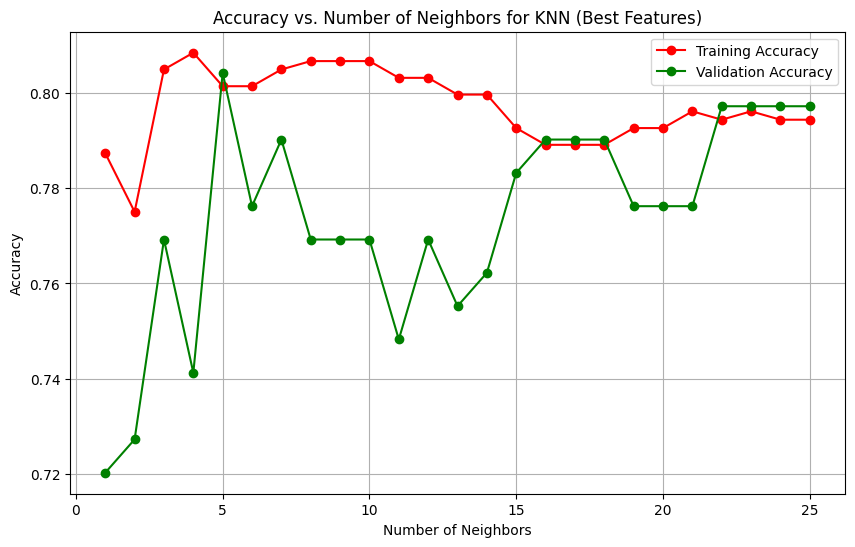

In [8]:
# Bereich der Nachbarn von 1 bis 25
neighbors_range = range(1, 26)
train_scores = []
valid_scores = []

# Trainieren und Validieren für jede Anzahl von Nachbarn
for n_neighbors in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train[best_features], y_train)
    y_train_pred = knn.predict(X_train[best_features])
    y_val_pred = knn.predict(X_val[best_features])
    train_scores.append(accuracy_score(y_train, y_train_pred))
    valid_scores.append(accuracy_score(y_val, y_val_pred))

# Diagramm: Genauigkeit vs. Anzahl der Nachbarn
plt.figure(figsize=(10, 6))
plt.plot(neighbors_range, train_scores, 'o-', color='r', label='Training Accuracy')
plt.plot(neighbors_range, valid_scores, 'o-', color='g', label='Validation Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors for KNN (Best Features)')
plt.legend()
plt.grid(True)
plt.show()


In [9]:

# Definieren des Parametergrids für GridSearchCV
param_grid = {
    'n_neighbors': range(1, 25),    # Anzahl der Nachbarn für KNN
    'weights': ['uniform', 'distance'],  # Gewichtung der Nachbarn
    'metric': ['euclidean', 'manhattan']  # Metriken für die Distanzberechnung
}

# Initialisieren des KNN-Klassifikators
knn = KNeighborsClassifier()

# Initialisieren von GridSearchCV mit 5-facher Kreuzvalidierung
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Ausführen der Suche auf den Trainingsdaten
grid_search.fit(X_train[best_features], y_train)

# Beste Parameter und Genauigkeit aus der Grid-Suche
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"Beste Parameter: {best_params}")
print(f"Beste Genauigkeit während des Trainings: {best_accuracy:.4f}")

# Modelltraining mit den besten Parametern auf dem Validierungsset
knn_best = KNeighborsClassifier(**best_params)
knn_best.fit(X_train[best_features], y_train)
y_pred = knn_best.predict(X_val[best_features])
val_accuracy = accuracy_score(y_val, y_pred)

print(f"Genauigkeit des Modells mit den besten Parametern auf dem Validierungsset: {val_accuracy:.4f}")


Beste Parameter: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
Beste Genauigkeit während des Trainings: 0.7874
Genauigkeit des Modells mit den besten Parametern auf dem Validierungsset: 0.7692


Weitere Methoden:
    -Random Decision Forest (Rauschtolleranz, Gewichtung von Spalten / fehlende Werte)
    -Support Vector Machine (gut bei hochdimensionalen Datensätzen)
    -Neuronales Netzwerk zum zeigen nicht mit Kanonen auf Spatzen schießen

In [13]:
df_test = pd.read_csv('titanic_test.csv')
df_test_with_survival = pd.read_csv('titanic_validate.csv')

X_test = df_test.drop(['Cabin', 'Ticket', 'Name'], axis=1)
X_test['Sex'] = X_test['Sex'].map({'male': 0, 'female': 1})
X_test['Embarked'] = X_test['Embarked'].map({'Q': 0, 'S': 1, 'C': 2})
X_test.fillna(X_train.mean(), inplace=True)  # Imputation von fehlenden Werten in den numerischen Spalten

# Modell trainieren
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train[best_features], y_train)

# 5. Vorhersagen auf den Testdaten treffen
y_test_pred = knn.predict(X_test[best_features])

# 6. Vergleich mit den tatsächlichen Überlebensdaten
df_test_with_survival['Predicted_Survived'] = y_test_pred
df_test_with_survival['Correct'] = df_test_with_survival['Survived'] == df_test_with_survival['Predicted_Survived']



# 7. Ergebnisse speichern
df_test_with_survival.to_csv('titanic_test_results.csv', index=False)

# Ausgabe der Ergebnisse
print("Ergebnisse gespeichert in 'titanic_test_results.csv'")

correct_predictions = df_test_with_survival['Correct'].sum()
total_predictions = len(df_test_with_survival)

accuracy = (correct_predictions / total_predictions) * 100
print(f"Genauigkeit: {accuracy:.2f}%")


Ergebnisse gespeichert in 'titanic_test_results.csv'
Genauigkeit: 77.99%


In [12]:
import ipywidgets as widgets
from IPython.display import display

knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train[best_features], y_train)

# Interaktive Vorhersage basierend auf PassengerId und Überprüfung der Vorhersage
def predict_survival_by_id_test(passenger_id):
    # Suche die Passagierdaten im Testdatensatz
    passenger_data = df_test[df_test['PassengerId'] == passenger_id]
    
    if passenger_data.empty:
        return f"PassengerId {passenger_id} not found.", None, None
    
    # Nur die besten Features für die Vorhersage verwenden
    passenger_data_for_prediction = passenger_data[best_features]

    # Map categorical variables as in the training data
    passenger_data_for_prediction['Sex'] = passenger_data_for_prediction['Sex'].map({'male': 0, 'female': 1})
    passenger_data_for_prediction['Embarked'] = passenger_data_for_prediction['Embarked'].map({'Q': 0, 'S': 1, 'C': 2})

    # Fill any missing values using the median
    passenger_data_for_prediction.fillna(X_train[best_features].median(), inplace=True)

    # Predict using the trained KNN model
    prediction = knn.predict(passenger_data_for_prediction)
    
    # Prepare the result message
    survival_result = 'Survived' if prediction[0] == 1 else 'Not Survived'
    
    # Extracting important features
    passenger_details = {
        "Name": passenger_data['Name'].values[0],
        "Age": passenger_data['Age'].values[0],
        "Gender": 'Female' if passenger_data['Sex'].values[0] == 'female' else 'Male',
        "Class": passenger_data['Pclass'].values[0],
        "Fare": passenger_data['Fare'].values[0],
        "Embarked": passenger_data['Embarked'].values[0],
        "Siblings/Spouses Aboard": passenger_data['SibSp'].values[0],
        "Parents/Children Aboard": passenger_data['Parch'].values[0]
    }
    
    # Überprüfe die Vorhersage mit den tatsächlichen Überlebensdaten aus dem Validate-Datensatz
    actual_survival_data = df_test_with_survival[df_test_with_survival['PassengerId'] == passenger_id]
    
    if actual_survival_data.empty:
        correctness = "N/A - Actual survival data not found"
    else:
        actual_survived = actual_survival_data['Survived'].values[0]
        correctness = 'Correct' if prediction[0] == actual_survived else 'Incorrect'
    
    return survival_result, passenger_details, correctness

# Widget für PassengerId-Eingabe
passenger_id_input_test = widgets.IntText(
    value=892,
    description='PassengerId:',
    disabled=False
)

# Ergebnisanzeige-Widgets
result_label_test = widgets.Label(value="Prediction:")
details_html_test = widgets.HTML(value="Details:")
correctness_label_test = widgets.Label(value="Correctness:")

# Event-Handler für den Button-Klick
def on_button_click_test(b):
    passenger_id = passenger_id_input_test.value
    result, details, correctness = predict_survival_by_id_test(passenger_id)
    result_label_test.value = f"Prediction: {result}"
    correctness_label_test.value = f"Correctness: {correctness}"
    
    if details:
        details_text = f"""
        <b>Name:</b> {details['Name']}<br>
        <b>Age:</b> {details['Age']}<br>
        <b>Gender:</b> {details['Gender']}<br>
        <b>Class:</b> {details['Class']}<br>
        <b>Fare:</b> {details['Fare']}<br>
        <b>Embarked:</b> {details['Embarked']}<br>
        <b>Siblings/Spouses Aboard:</b> {details['Siblings/Spouses Aboard']}<br>
        <b>Parents/Children Aboard:</b> {details['Parents/Children Aboard']}
        """
        details_html_test.value = details_text
    else:
        details_html_test.value = "Details: Passenger not found."

# Button erstellen
submit_button_test = widgets.Button(
    description='Submit',
    button_style='success',  
    tooltip='Click to make prediction'
)

# Button-Klick mit der Event-Funktion verknüpfen
submit_button_test.on_click(on_button_click_test)

# Anzeige der Widgets
display(widgets.VBox([widgets.HBox([passenger_id_input_test, submit_button_test]), result_label_test, correctness_label_test, details_html_test]))

C:\Users\alexa\AppData\Local\Temp\ipykernel_20888\4227483134.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passenger_data_for_prediction['Sex'] = passenger_data_for_prediction['Sex'].map({'male': 0, 'female': 1})
C:\Users\alexa\AppData\Local\Temp\ipykernel_20888\4227483134.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passenger_data_for_prediction['Embarked'] = passenger_data_for_prediction['Embarked'].map({'Q': 0, 'S': 1, 'C': 2})
C:\Users\alexa\AppData\Local\Temp\ipykernel_20888\4227483134.p